# Function Testing

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
from importlib import reload

In [23]:
import funcs
import filt_funcs as ff
reload(funcs)
reload(ff)

<module 'filt_funcs' from '/home.ufs/amf2288/argo-intern/filt_funcs.py'>

## Load aselect example data

In [24]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=ff.get_ds_interp(box,0,2000,4)

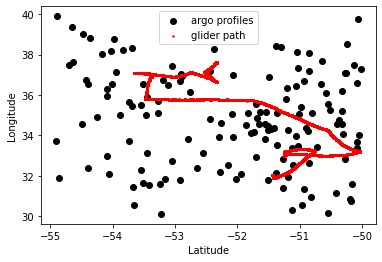

In [25]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

## Dhruv's filtering method

In [26]:
dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

In [27]:
f1 = aselect.TEMP.isel(N_PROF=0)
f1_num = int(f1.N_PROF_NEW)

f1_hat = funcs.my_filter1d(f1.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f1_gauss = funcs.my_filter1d(f1.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

f2 = aselect.TEMP.isel(N_PROF=120)
f2_num = int(f2.N_PROF_NEW)

f2_hat = funcs.my_filter1d(f2.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f2_gauss = funcs.my_filter1d(f2.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

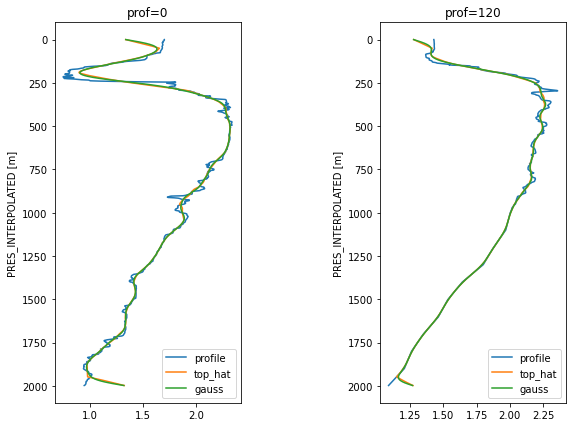

In [28]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,3,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_hat, x, label='top_hat')
plt.plot(f1_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,3,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_hat, x, label='top_hat')
plt.plot(f2_gauss, x, label='gauss')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplots_adjust(wspace=0.75)

## Filtering Functions

#### Create Mask

In [61]:
def get_mask(ds, scale, dim2='PRES_INTERPOLATED', bound=False):
    
    if bound==False:
        mask = np.ones((len(ds[dim2])))
        
    if bound==True:
        start = ds[dim2].isel({dim2:0}).values + (scale-1)
        end = ds[dim2].isel({dim2:-1}) - (scale-1)
        mask = ds[dim2].where(ds[dim2]>start).where(ds[dim2]<end).values
        
        mask[np.greater(mask,0)] = 1
        mask[np.isnan(mask)] = 0
    
    return mask

#### Create filter scales

In [62]:
def get_lfilters(first, last, num, log=False):
    
    if log==False:
        lfilters = np.linspace(first, last, num)
        
    if log==True:
        first_exp = np.log10(first)
        last_exp = np.log10(last)
        lfilters = np.logspace(first_exp, last_exp, num)
        
    return lfilters

In [64]:
def get_nfilters(ds, lfilters, dim2='PRES_INTERPOLATED'):
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values    
    sigmafilters = np.empty_like(lfilters)
    nfilters = np.empty_like(lfilters)
    
    for n, l in enuerate(lfilters):
        sigmafilters[n] = l/np.sqrt(12)
        nfilters[n] = sigmafilters[n]/dx
        
    return nfilters

In [71]:
def get_nfilter(ds, lfilter, dim2='PRES_INTERPOLATED'):
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    return nfilter

#### Filter at one scale

In [142]:
def get_filt_single(ds, lfilter, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False):
    
    mask = get_mask(ds, lfilter, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(ds, lfilter, dim2=dim2)
    
    temp = np.zeros((ds[dim1].shape[0], ds[dim2].shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds[variable], sigma=nfilter, mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED'], coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2]})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds_filt[dim2].dims)
    
    return ds_filt

In [143]:
single_filt = get_filt_single(aselect, 100, bound=True)

#### Filter at multiple scales

In [144]:
# not sure where single and multiple should interface
    #for single: lfilter provided, only one nfilt calculated
    #for multi: lfilters and nfilters need to be calculated
#so maybe the move is calling get_lfilters
#then writing a loop that calls get_filt_single for each lfilter and creating filt output
#finally organize it all in an array

In [145]:
#should probably add some documentation to these, especially to specify which dim is filtered
def get_filt_multi(ds, first, last, num, variable='TEMP', dim1='N_PROF', dim2='PRES_INTERPOLATED', bound=False, log=False):
    
    lfilters = get_lfilters(first=first, last=last, num=num, log=log)
    
    temp=np.zeros((ds[dim1].shape[0],ds[dim2].shape[0],num))
    for n in range(0,num):
        temp[:,:,n] = get_filt_single(ds=ds, lfilter=lfilters[n], variable=variable, dim1=dim1, dim2=dim2, bound=bound)
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED', 'FILT_SCALE'], 
                           coords={'N_PROF':ds[dim1], 'PRES_INTERPOLATED':ds[dim2], 'FILT_SCALE':lfilters})
    
    number=np.arange(0,len(ds[dim1]))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds[dim1].dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds[dim2].dims)
    
    return ds_filt

In [149]:
multi_lin_False = get_filt_multi(aselect, 10,500,50)
multi_log_False = get_filt_multi(aselect, 10,500,50, log=True)

multi_lin_True = get_filt_multi(aselect, 10,500,50, bound=True)
multi_log_True = get_filt_multi(aselect, 10,500,50, bound=True, log=True)

## Compare Dhruv's functions to mine

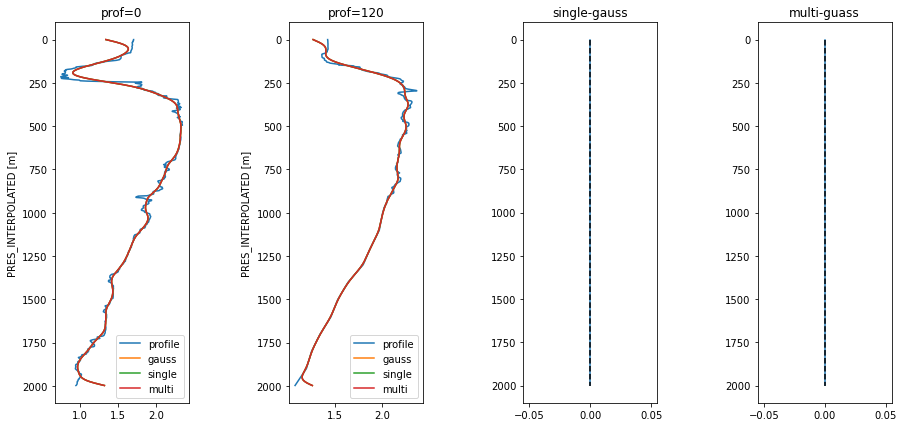

In [148]:
plt.figure(figsize=(15,7))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,4,1)
plt.plot(f1, x, label='profile')
plt.plot(f1_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f1_num), x, label='single')
plt.plot(multi_filt.isel(N_PROF=f1_num).sel(FILT_SCALE=100.), x, label='multi')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f1_num))
plt.legend()

plt.subplot(1,4,2)
plt.plot(f2, x, label='profile')
plt.plot(f2_gauss, x, label='gauss')
plt.plot(single_filt.isel(N_PROF=f2_num), x, label='single')
plt.plot(multi_filt.isel(N_PROF=f2_num).sel(FILT_SCALE=100.), x, label='multi')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.title("prof={}".format(f2_num))
plt.legend()

plt.subplot(1,4,3)
plt.plot(single_filt.isel(N_PROF=f1_num)-f1_gauss, aselect.PRES_INTERPOLATED)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("single-gauss")

plt.subplot(1,4,4)
plt.plot(single_filt.isel(N_PROF=f2_num)-f2_gauss, aselect.PRES_INTERPOLATED)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title("multi-guass")

plt.subplots_adjust(wspace=0.75)